# spanish to English

In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf

# import tensorflow_text as tf_text


2024-09-20 11:24:42.735103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 11:24:42.743907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 11:24:42.753377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 11:24:42.756163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 11:24:42.763606: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    "spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)

path_to_file = pathlib.Path(path_to_zip).parent / "spa-eng/spa.txt"


In [3]:
def load_data(path):
    text = path.read_text(encoding="utf=8")

    lines = text.splitlines()
    pairs = [line.split("\t") for line in lines]

    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])

    return target, context


In [4]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])
print(target_raw[-1])


Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [5]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

# creates a boolean mast for samples selected for training or not
# meaning a sample that is True will be assigned to training set and false will not
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

print(is_train.shape)

train_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

val_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)


train_raw


(118964,)


I0000 00:00:1726845884.507002   75441 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726845884.524779   75441 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726845884.524819   75441 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726845884.527521   75441 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726845884.527585   75441 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [6]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break


tf.Tensor(
[b'Sois demasiado est\xc3\xbapidas para vivir.'
 b'Mi padre se ha hecho mayor.' b'\xc3\x89l no sab\xc3\xada nadar.'
 b'Ellos se casaron.' b'\xc2\xbfCu\xc3\xa1les son sus funciones?'], shape=(5,), dtype=string)

tf.Tensor(
[b"You're too stupid to live." b'My father grew old.'
 b'He could not swim.' b'They got married.' b'What are your duties?'], shape=(5,), dtype=string)


# TExt preprocessing

In [7]:
# from tensorflow import text


example_text = tf.constant("¿Todavía está en casa?")
print(example_text.numpy())
# print(tf.text.normalize_utf8(example_text, "NFKD").numpy())


b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'


In [8]:
# Since tensorflow_text doesn't work
import unicodedata

"""
*** FORMS *** 
NFC
NFD
NFKC
NFKD

"""
example = "¿Todavía está en casa?"


def unicode_normalize(form, src):
    # src = str(tf.get_static_value(src))
    norm = unicodedata.normalize(form, src)
    # print(f"{form}: {norm} ({len(norm.encode('utf-8'))} bytes)")
    return norm


unicode_normalize("NFKD", example)


'¿Todavía está en casa?'

In [9]:
# import unicodedata


# def conv_and_print(form):
#     src = "¿Todavía está en casa?"
#     norm = unicodedata.normalize(form, src)
#     print(f"{form}: {norm} ({len(norm.encode('utf-8'))} bytes)")


# conv_and_print("NFC")
# conv_and_print("NFD")
# conv_and_print("NFKC")
# conv_and_print("NFKD")


In [10]:
def tf_lower_and_split_punct(text):
    # Split accented Characters.
    # text = unicode_normalize("NFKD", text)
    text = tf.strings.lower(text)

    # keep space, a to z, and selcet punctuation
    text = tf.strings.regex_replace(text, "[^ a-z.?!,¿]", "")

    # add spaces around punctuation.
    text = tf.strings.regex_replace(text, "[.?!,¿]", r" \0 ")

    # strip white space.
    text = tf.strings.strip(text)

    text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
    return text


In [11]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())


¿Todavía está en casa?
[START] ¿ todava est en casa ? [END]


# Vectorization

In [12]:
max_cocab_size = 5000
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, max_tokens=max_cocab_size, ragged=True
)


## Spanish text vectorizer

In [13]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# print first 10 words from the vocabulary
context_text_processor.get_vocabulary()[:10]


2024-09-20 11:24:51.358712: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['', '[UNK]', '[START]', '[END]', '.', 'de', 'que', 'a', 'no', 'tom']

## English text vectorizer

In [14]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, max_tokens=max_cocab_size, ragged=True
)
target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]


2024-09-20 11:24:57.668376: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

### convert batch of strings to batch of token IDs

In [15]:
example_tokens = context_text_processor(example_context_strings)
print(example_tokens.shape)
example_tokens[:3]


(64, None)


<tf.RaggedTensor [[2, 1318, 134, 3258, 33, 304, 4, 3], [2, 27, 131, 18, 63, 176, 351, 4, 3],
 [2, 20, 8, 186, 332, 4, 3]]>

In [16]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
" ".join(tokens)


'[START] sois demasiado estpidas para vivir . [END]'

Text(0.5, 1.0, 'Mask')

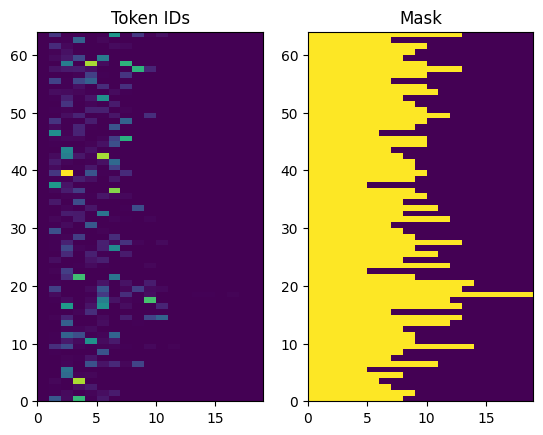

In [17]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title("Token IDs")

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title("Mask")


## Process the dataset

In [19]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:, :-1].to_tensor()
    targ_out = target[:, 1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)


In [25]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy())
    print()
    print(ex_tar_in[0, :10].numpy())
    print(ex_tar_out[0, :10].numpy())


[  2  73   6  20  22 577 242   4   3   0]

[  2  13 191  21 290  17   4   0   0   0]
[ 13 191  21 290  17   4   3   0   0   0]


2024-09-20 11:32:30.232541: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
